In [1]:
%load_ext autoreload
%autoreload 2
    
from bmp_config import path_data,envcode2env
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from bmp_behav_proc import *

import numpy as np
from pingouin import ttest
from bmp_base import radius_cursor
import bmp_behav_proc

In [2]:
from datetime import datetime

fnf = pjoin(path_data,'df_all_multi_tsz__.pkl.zip')
print(fnf)
print( str(datetime.fromtimestamp(os.stat(fnf).st_mtime)))
df_all_multi_tsz = pd.read_pickle(fnf)
print(df_all_multi_tsz['trial_group_col_calc'].unique())
print(df_all_multi_tsz['retention_factor_s'].unique())
# df = df_all_multi_tsz.query('trial_shift_size == 1 and trial_group_col_calc == "trialwe" '
#                             ' and retention_factor_s == "1.000"').copy()
df_all_multi_tsz_orig = df_all_multi_tsz

/p/project1/icei-hbp-2022-0017/memerr/data2/df_all_multi_tsz__.pkl.zip
2025-05-27 16:35:00.938169
['trials' 'trialwtgt' 'trialwe' 'trialwtgt_we']
['1.000' '0.924']


In [ ]:
# prepare for generalization analysis
import bmp_behav_proc
stds = bmp_behav_proc._calcStds(df)
stds = stds.to_frame().reset_index().rename(columns={'error_deg':'error_deg_initstd'}) 

print( df_all_multi_tsz.trial_group_col_calc.unique() )

df_all_multi_tsz_whtr = df_all_multi_tsz.merge(stds, on='subject')
df_all_multi_tsz_whtr_ = df_all_multi_tsz_whtr.\
    query('trial_group_col_calc in ["trialwe", "trialwtgt_we"]').copy()

df_all_multi_tsz_whtr_['env'] = df_all_multi_tsz_whtr_['environment'].apply(lambda x: envcode2env[x])

df_all_multi_tsz_whtr_['error_deg'] = df_all_multi_tsz_whtr_['error'] / np.pi * 180 
df_all_multi_tsz_whtr_['error_initstd'] = df_all_multi_tsz_whtr_.error_deg_initstd /  180 * np.pi 

print('trial_group_col_calc uniue = ', df_all_multi_tsz['trial_group_col_calc'].unique() )


checkErrBounds(df,['error','prev_error','error_deg'])
checkErrBounds(df_all_multi_tsz_whtr_,['error','prev_error','error_deg'])

shiftszs = df_all_multi_tsz_whtr_['trial_shift_size'].unique()
print(shiftszs)

_cols = [col for col in df_all_multi_tsz.columns if col.find('like') >= 0]
print(_cols)

# truncate multi-ver ES
# remove trials with error > std_mult * std of error
dfall_notclean = df_all_multi_tsz_whtr_.query('err_sens.abs() <= @ES_thr')

dfall_mshsz = truncateDf(dfall_notclean, 'err_sens', q=0.0, infnan_handling='discard', 
       cols_uniqify = ['subject','environment','trial_shift_size',
                       'trial_group_col_calc','retention_factor_s'])


In [ ]:
#dfall_mshsz = pd.read_pickle(pjoin(path_data, 'dfall_mshsz.pkl' ) ) 
dfc_multi_tsz = dfall_mshsz.query('retention_factor_s == "0.924"')

In [5]:
print('min,max ES {:.3f}, {:.3f}'.format( dfc_multi_tsz.err_sens.min(), dfc_multi_tsz.err_sens.max() ) )
assert dfc_multi_tsz['retention_factor_s'].nunique() == 1

min,max ES -6.927, 6.932


In [6]:
df_ = dfc_multi_tsz.query('trial_shift_size > 1 and trial_group_col_calc == "trialwe"')
neq = (df_['dist_rad_from_prevtgt_shiftrespect'] != df_['dist_rad_from_prevtgt2']).sum()
eq = (df_['dist_rad_from_prevtgt_shiftrespect'] == df_['dist_rad_from_prevtgt2']).sum()
print( neq/len(df_), eq/len(df_))

0.6929443302188794 0.3070556697811207


In [7]:
#distcol = 'dist_rad_from_prevtgt2'
distcol = 'dist_rad_from_prevtgt_shiftrespect'

drs = dfc_multi_tsz[distcol].unique();
drs_f = np.array( list(map( float, drs) ) )
drs = list(sorted(drs,key = lambda x: float(x)))


#dfc_s = dfc[dfc['trial_group_col_calc'] == 'trialwtgt_we']
# TODO: should I restrict to one env?
dfc_s = dfc_multi_tsz.query('trial_group_col_calc == "trialwe"')
grp = dfc_s.groupby(['trial_shift_size', distcol])
dts = dfc_multi_tsz['trial_shift_size'].unique()
nt = len(dts)

print(drs, dts)

assert nt == 4, nt
assert len(drs) == 4, len(drs)

['0.00', '0.79', '1.57', '2.36'] [1 2 3 4]


In [8]:
drpairs = [(drs[i],drs[i+1] ) for i in range(3)]
drpairs += [(drs[0],drs[i] ) for i in range(2,4)]
drpairs += [(drs[1],drs[3] )]
print(drpairs)

dtpairs = [(dts[i],dts[i+1] ) for i in range(3)]
dtpairs += [(dts[0],dts[i] ) for i in range(2,4)]
dtpairs += [(dts[1],dts[3] )]
dtpairs

[('0.00', '0.79'), ('0.79', '1.57'), ('1.57', '2.36'), ('0.00', '1.57'), ('0.00', '2.36'), ('0.79', '2.36')]


[(np.int64(1), np.int64(2)),
 (np.int64(2), np.int64(3)),
 (np.int64(3), np.int64(4)),
 (np.int64(1), np.int64(3)),
 (np.int64(1), np.int64(4)),
 (np.int64(2), np.int64(4))]

In [9]:
from figure.plots import plotPolys_genplot as plotPolys
from figure.plots import getPvals_genplot as getPvals

starcode_precalc='****', 4.779214481588924e-09
starcode_precalc='****', 4.5792025275927096e-09
starcode_precalc='****', 1.516270460433102e-07
starcode_precalc='**', 0.0048591247103577425
starcode_precalc='**', 0.0024256971659505112
starcode_precalc='ns', 0.18912426557074222
  dist_rad_from_prevtgt_shiftrespect          pval
0                               0.00  4.854129e-10
1                               0.79  3.719856e-06
2                               1.57  1.249407e-02
3                               2.36  4.011583e-02
dist_rad_from_prevtgt_shiftrespect == '0.00'
20
dist_rad_from_prevtgt_shiftrespect == '0.79'
20
dist_rad_from_prevtgt_shiftrespect == '1.57'
20
dist_rad_from_prevtgt_shiftrespect == '2.36'
20
0.0 [0.   0.79 1.57 2.36] [0.   0.79 1.57 2.36] [0.68901466 0.28314381 0.15563259 0.1355745 ]
[0.   0.79 1.57 2.36]
[0.   0.79 1.57 2.36] [0.68901466 0.28314381 0.15563259 0.1355745 ]


/tmp/ipykernel_18745/1035832355.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['same target', 45, 90, 135])


starcode_precalc='****', 5.918283194700167e-07
starcode_precalc='****', 4.9268658334546e-09
starcode_precalc='****', 6.49178872682511e-07
starcode_precalc='ns', 0.8764907743174378
starcode_precalc='ns', 0.9797565083494533
starcode_precalc='ns', 0.9797565083494533
   trial_shift_size          pval
0                 1  4.854129e-10
1                 2  3.341416e-03
2                 3  2.272377e-02
3                 4  4.256464e-03
trial_shift_size == '1'
20
trial_shift_size == '2'
20
trial_shift_size == '3'
20
trial_shift_size == '4'
20
1.0 [1. 2. 3. 4.] [0. 1. 2. 3.] [0.68901466 0.18741133 0.06283997 0.14195267]
[1. 2. 3. 4.]
[0. 1. 2. 3.] [0.68901466 0.18741133 0.06283997 0.14195267]
starcode_precalc='****', 2.1285687669307412e-06
starcode_precalc='****', 3.8239561986722975e-06
starcode_precalc='****', 4.4051700953497046e-06
starcode_precalc='ns', 0.23245631508145762
starcode_precalc='ns', 0.0773809170848646
starcode_precalc='ns', 0.9229145242697798
   trial_shift_size          pval
0

/tmp/ipykernel_18745/1035832355.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['same target', 45, 90, 135])


starcode_precalc='****', 4.002252587782185e-05
starcode_precalc='****', 7.472186746321535e-08
starcode_precalc='****', 1.0415955590423847e-06
starcode_precalc='ns', 1.0
starcode_precalc='ns', 0.45185689194831924
starcode_precalc='ns', 1.0
   trial_shift_size          pval
0                 1  2.205913e-09
1                 2  3.785918e-02
2                 3  1.441261e-01
3                 4  1.558558e-01
trial_shift_size == '1'
20
trial_shift_size == '2'
20
trial_shift_size == '3'
20
trial_shift_size == '4'
20
1.0 [1. 2. 3. 4.] [0. 1. 2. 3.] [0.53168645 0.13931583 0.02735165 0.08698186]
[1. 2. 3. 4.]
[0. 1. 2. 3.] [0.53168645 0.13931583 0.02735165 0.08698186]
starcode_precalc='***', 0.0008275118474831442
starcode_precalc='****', 1.1689205421159513e-06
starcode_precalc='***', 0.00011453130631689274
starcode_precalc='ns', 0.8293660490890504
starcode_precalc='ns', 0.8293660490890504
starcode_precalc='ns', 0.8293660490890504
   trial_shift_size      pval
0                 1  0.000003
1   

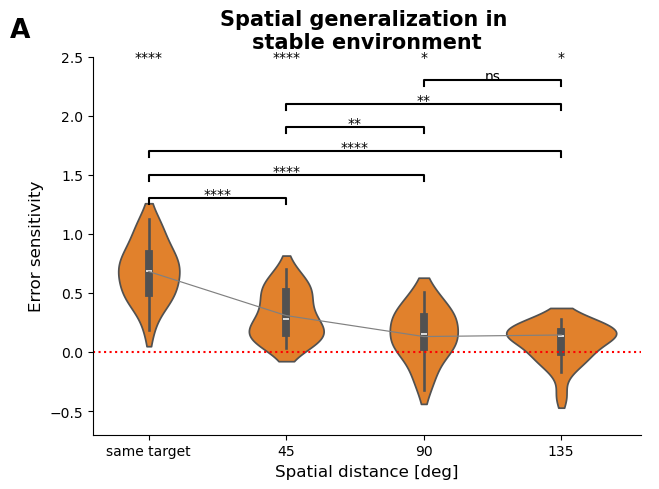

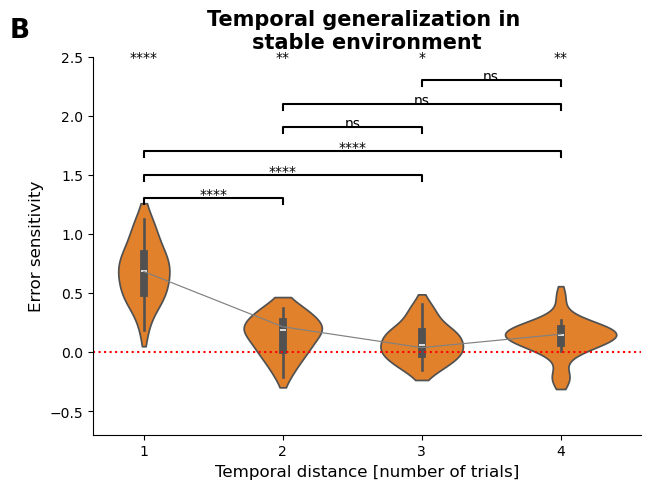

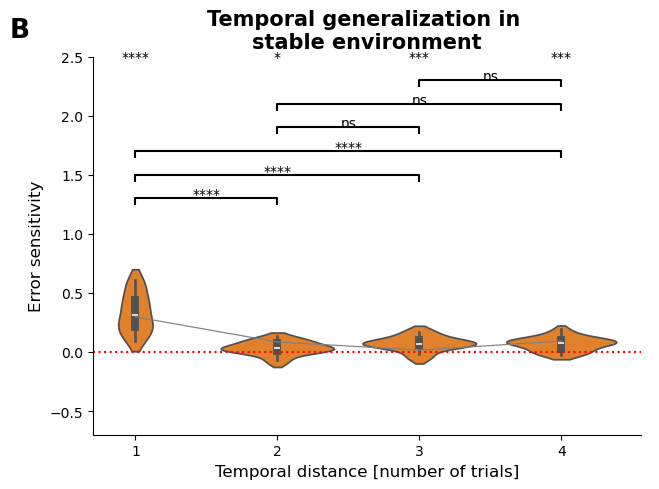

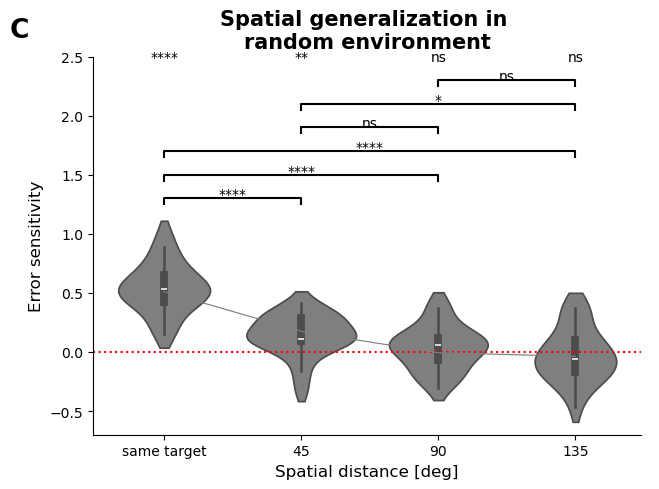

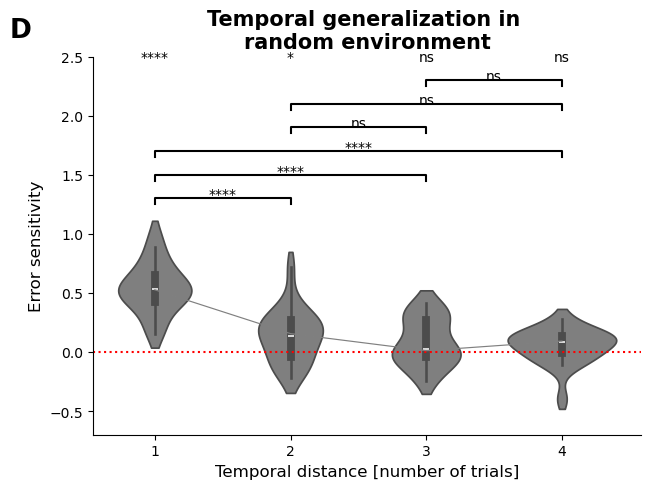

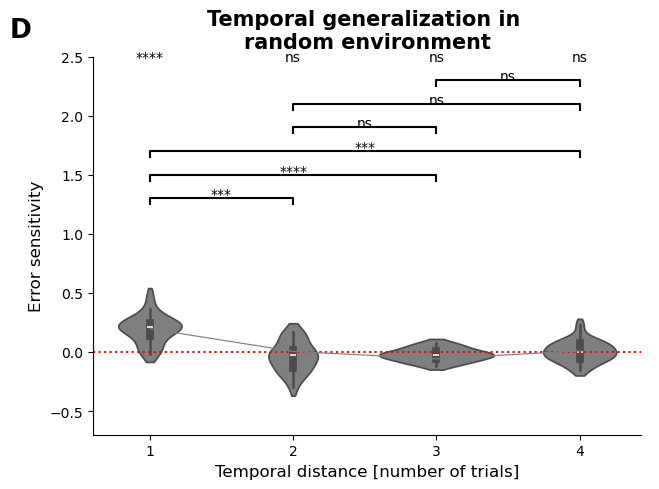

In [11]:
from figure.mystatann import plotSigAll, plotSig0All
from figure import env_order,palette_stabrand,env2color
# not pooled
#%debug
text_shift = (-60, 20)
annot_loc = (0, 1.03)

hue = 'env'
mcorr = 'holm'
#env2color = {'stable':'lightblue', 'random':'orange'}
aspect=1.3
#rng = [2]
#rng = [2,3,4,5,6,7]
rng = [2]
ylim = [-2,3]
ylim_plot = [-0.7,2.5]
meanfit=1
#qs_spatial = f'trial_group_col_calc == "trialwe" and err_sens >= {ylim[0]} and err_sens <= {ylim[1]} and trial_shift_size == 1'
qs_spatial = f'trial_group_col_calc == "trialwe" and trial_shift_size == 1'
qs_temporal = f'trial_group_col_calc == "trialwe" and {distcol} == "0.00"'
qs_temporal_naive = f'trial_group_col_calc == "trialwe"'  # use all trials
#bnqs = [  ('grid_line_violin_spatial','Spatial distance [deg]',drs,drpairs,'dist_rad_from_prevtgt2', f'trial_group_col_calc == "trialwe" and err_sens >= {ylim[0]} and err_sens <= {ylim[1]} and trial_shift_size == 1'),
#        ( 'grid_line_violin_temporal','Temporal distance [number of trials]',dts,dtpairs,'trial_shift_size','trial_group_col_calc == "trialwe" and dist_rad_from_prevtgt2 == "0.00"')]
bnqs = {'grid_line_violin_spatial': ('Spatial distance [deg]',drs,drpairs,
            distcol, qs_spatial),
        'grid_line_violin_temporal':('Temporal distance [number of trials]',dts,dtpairs,
            'trial_shift_size',qs_temporal),
       'grid_line_violin_temporal_naive':('Temporal distance [number of trials]',dts,dtpairs,
            'trial_shift_size',qs_temporal_naive)}
panel_letters = ['A','B','B','C','D','D']
paneli  = 0

dfr = []
ttrs0s = []
for env_type in ['stable','random']:
    color = env2color[env_type]
#    for bn,xlab,order,pairs,fitcol,qs in bnqs:
    for bn,(xlab,order,pairs,fitcol,qs) in bnqs.items():
        #qs0 = f'trial_group_col_calc == "trialwe" and err_sens >= {ylim[0]} and err_sens <= {ylim[1]}'
        #qs = qs + ' and trial_shift_size == 1'
        if env_type in ['stable', 'random']:
            qs += ' and env == @env_type'
            hue = None
            
        dftmp0 = dfc_multi_tsz.query(qs).groupby(['subject','environment',fitcol])
        dftmp0 = dftmp0.mean(numeric_only = True).reset_index()                
        dfr += [dftmp0]

        #dftmp0 = dfc_multi_tsz.query(qs)
        #fitcol = 'dist_rad_from_prevtgt2'
        fg = sns.catplot(kind='violin', data=dftmp0, y='err_sens', 
                         hue=hue, x=fitcol, order = order,
                          color=color, aspect=aspect, cut=True)
        #dftmp = dfc_multi_tsz.query(qs).copy()
        dftmp = dftmp0.copy()
        #pvalues, formatted_pvalues = getPvals(dftmp,fitcol, pairs)

        ax = fg.axes.flatten()[0]
        ttrs,ttrs_sig = plotSigAll(ax, 1.3, 0.2, 0.05, df=dftmp, 
                   coln = 'err_sens', colpair = fitcol,
                  verbose = 0, multi_comp_corr_method=mcorr)
        ttrs0,ttrs0_sig = plotSig0All(ax, 2.5, txt=None, df=dftmp, 
                   coln = 'err_sens', colpair = fitcol,
                  multi_comp_corr_method=mcorr, graded_signif = True, show_ns = True)
        ttrs0['bn'] = bn
        ttrs0['env'] = env_type
        ttrs0['fitcol'] = fitcol
        ttrs0s += [ttrs0]

        if bn.find('_spatial') >= 0:
            pref = 'Spatial generalization in \n'
        else:
            pref = 'Temporal generalization in \n'
        for ax in fg.axes.flatten():
            ax.axhline(0,ls=':',c='r')
            ax.set_ylabel('Error sensitivity', fontdict={'fontsize':12})
            ax.set_xlabel(xlab, fontdict={'fontsize':12} )
            if bn == 'grid_line_violin_spatial':
                ax.set_xticklabels(['same target', 45, 90, 135])            
            ax.set_title(pref + f'{env_type} environment', y = 1,
                        fontdict={'fontsize':15, 'fontweight':'bold'})

        ax.annotate(panel_letters[paneli], xy=annot_loc, xytext=text_shift, 
        fontsize=19, fontweight='bold', va='top', ha='left',
            xycoords='axes fraction', textcoords='offset points')

        ax.set_ylim(ylim_plot)

        plotPolys(ax,dftmp,fitcol, degs=rng, mean=meanfit)
        plt.tight_layout()
        #bn = 'grid_line_violin_spatial'
        plt.savefig(pjoin(path_fig,'behav',f'nopool_{env_type}_{bn}.svg'))
        plt.savefig(pjoin(path_fig,'behav',f'nopool_{env_type}_{bn}.pdf'))
        paneli += 1

    #     break
    # break
ttrs0s = pd.concat(ttrs0s, ignore_index=True)

In [15]:
ttrs0s.columns

Index(['T', 'dof', 'alternative', 'pval', 'CI95%', 'cohen-d', 'BF10', 'power',
       'alt', 'val1', 'N1', 'ttstr', 'dist_rad_from_prevtgt_shiftrespect',
       'pval_uncorr', 'mc_corr_method', 'starcode', 'varval', 'bn', 'env',
       'fitcol', 'trial_shift_size'],
      dtype='object')

In [16]:
ttrs0s[['bn', 'env', 'T','pval','alt','ttstr','fitcol','varval','mc_corr_method',
        'trial_shift_size','dist_rad_from_prevtgt_shiftrespect']]

,bn,env,T,pval,alt,ttstr,fitcol,varval,mc_corr_method,trial_shift_size,dist_rad_from_prevtgt_shiftrespect
0,grid_line_violin_spatial,stable,12.548465,1.213532e-10,two-sided,err_sens != 0,dist_rad_from_prevtgt_shiftrespect,NaN,NaN,NaN,0.00
1,grid_line_violin_spatial,stable,6.960981,1.239952e-06,two-sided,err_sens != 0,dist_rad_from_prevtgt_shiftrespect,NaN,NaN,NaN,0.79
2,grid_line_violin_spatial,stable,3.073965,6.247035e-03,two-sided,err_sens != 0,dist_rad_from_prevtgt_shiftrespect,NaN,NaN,NaN,1.57
3,grid_line_violin_spatial,stable,2.203268,4.011583e-02,two-sided,err_sens != 0,dist_rad_from_prevtgt_shiftrespect,NaN,NaN,NaN,2.36
4,grid_line_violin_spatial,stable,12.548465,4.854129e-10,two-sided,err_sens != 0,dist_rad_from_prevtgt_shiftrespect,0.00,holm,NaN,0.00
5,grid_line_violin_spatial,stable,6.960981,3.719856e-06,two-sided,err_sens != 0,dist_rad_from_prevtgt_shiftrespect,0.79,holm,NaN,0.79
6,grid_line_violin_spatial,stable,3.073965,1.249407e-02,two-sided,err_sens != 0,dist_rad_from_prevtgt_shiftrespect,1.57,holm,NaN,1.57
7,grid_line_violin_spatial,stable,2.203268,4.011583e-02,two-sided,err_sens != 0,dist_rad_from_prevtgt_shiftrespect,2.36,holm,NaN,2.36
8,grid_line_violin_temporal,stable,12.548465,1.213532e-10,two-sided,err_sens != 0,trial_shift_size,NaN,NaN,1.0,NaN
9,grid_line_violin_temporal,stable,3.836205,1.113805e-03,two-sided,err_sens != 0,trial_shift_size,NaN,NaN,2.0,NaN


In [17]:
fitcol

'trial_shift_size'

In [18]:
#         from statannotations.Annotator import Annotator    
#         annotator = Annotator(ax,pairs, data=dftmp0, x=fitcol, y='err_sens',
#                              plot='violinplot', order=order)
#         #annotator.set_custom_annotations(formatted_pvalues)
#         annotator.set_pvalues(pvalues)
#         annotator.annotate()
## qs_temporal_naive = f'trial_group_col_calc == "trialwe"'  # use all trials

In [12]:
# make a 2x2 file
from figure.imgfilemanip import  stackSVGandShowJupy, svg2png
svg_fnames = []
#use_all_trials_for_temporal = True # True gives naive, flase give first version 
use_all_trials_for_temporal = False  # what will go to main 4x4 pic
bnsuff2fnsuff={'_naive':'_naive_temporal', '':'' }  # bn suffix to file name suffix

if use_all_trials_for_temporal:
    suff_bn = '_naive'; suff_bn_opposite = '' #; suff2= '_naive_temporal'  
else:
    suff_bn = ''; suff_bn_opposite = '_naive'  #; suff2= ''
suff2 = bnsuff2fnsuff[suff_bn]
for env_type in ['stable','random']:
    for bn in ['grid_line_violin_spatial','grid_line_violin_temporal' + suff_bn]:
        fnf = pjoin(path_fig,'behav',f'nopool_{env_type}_{bn}.svg')
        svg_fnames += [fnf]

show = 0
fnfout1 = pjoin(path_fig,'behav',f'nopool_stable{suff2}.svg')
stackSVGandShowJupy(svg_fnames[:2], 'horizontal', fnfout1, show=show) # stable horizontally
fnfout2 = pjoin(path_fig,'behav',f'nopool_random{suff2}.svg')
stackSVGandShowJupy(svg_fnames[2:], 'horizontal', fnfout2, show=show) # random horizontally

fnfout = pjoin(path_fig,'behav',f'generalization_2x2_nopool{suff2}.svg')
stackSVGandShowJupy([fnfout1,fnfout2], 'vertical', fnfout, show=show)

svg2png(fnfout, dpi=300)

Stacking with stack_type='horizontal' ['/p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_stable_grid_line_violin_spatial.svg', '/p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_stable_grid_line_violin_temporal.svg']
stack_svg: widths=(476.0, 476.0), heights=(360.0, 360.0)
SVG files have been combined and saved as /p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_stable.svg
Stacking with stack_type='horizontal' ['/p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_random_grid_line_violin_spatial.svg', '/p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_random_grid_line_violin_temporal.svg']
stack_svg: widths=(476.0, 476.0), heights=(360.0, 360.0)
SVG files have been combined and saved as /p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_random.svg
Stacking with stack_type='vertical' ['/p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_stable.svg', '/p/project1/icei-hbp-2022-0017/memerr

'/p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/generalization_2x2_nopool_dpi=300.png'

In [13]:
svg_fnames = []
for env_type in ['stable','random']:
    for bn in ['grid_line_violin_temporal' + suff_bn_opposite]:
        fnf = pjoin(path_fig,'behav',f'nopool_{env_type}_{bn}.svg')
        svg_fnames += [fnf]

suff2 = bnsuff2fnsuff[suff_bn_opposite]

show = 0
fnfout1 = pjoin(path_fig,'behav',f'nopool_temporal{suff2}.svg')
stackSVGandShowJupy(svg_fnames[:2], 'vertical', fnfout1, show=show)

svg2png(fnfout1, dpi=300)

Stacking with stack_type='vertical' ['/p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_stable_grid_line_violin_temporal_naive.svg', '/p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_random_grid_line_violin_temporal_naive.svg']
stack_svg: widths=(476.0, 476.0), heights=(360.0, 360.0)
total_width=476.0, total_height=720.0
SVG files have been combined and saved as /p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_temporal_naive_temporal.svg
Saved to /p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_temporal_naive_temporal_dpi=300.png


'/p/project1/icei-hbp-2022-0017/memerr/output_plots2/behav/nopool_temporal_naive_temporal_dpi=300.png'

In [92]:
# compute mean pearson corr between temporal/spatial distance and err sens
dfr = []
method='spearman'
for bn,(xlab,order,pairs,fitcol,qs) in bnqs.items():
    dftmp0 = dfc_multi_tsz.query(qs).groupby(['subject','env',fitcol])
    dftmp0 = dftmp0.mean(numeric_only = True).reset_index()
    #dftmp0['thr'] = "_"
    dftmp0[fitcol] = dftmp0[fitcol].astype(float)
    corrme,corrme_sep = corrMean(dftmp0, coltocorr=fitcol, 
        stagecol='env' , coln='err_sens', method=method)
    corrme_sep['antype'] = bn
    dfr += [corrme_sep.reset_index()]
dfr = pd.concat(dfr, ignore_index=True)

/p/project/icei-hbp-2022-0017/mambaforge/envs/merrbeh_py3113/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/p/project/icei-hbp-2022-0017/mambaforge/envs/merrbeh_py3113/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/p/project/icei-hbp-2022-0017/mambaforge/envs/merrbeh_py3113/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to estimate power (n <= 4). Returning NaN.
  warnings.warn("Sample size is too small to estimate power (n <= 4). Returning NaN.")
/p/project/icei-hbp-2022-0017/mambaforge/envs/merrbeh_py3113/lib/python3.11/site-packages/pingouin/power.py:861: UserWarning: Sample size is too small to est

In [105]:
ttrss = []
for antype in bnqs.keys():
    for env in dfr.env.unique():
        ttrs = compare0(dfr.query('antype == @antype and env == @env'), 'r', ['less'], 'r')
        ttrs['antype'] = antype
        ttrs['env'] = env
        ttrss += [ttrs]
ttrs = pd.concat(ttrss, ignore_index=True)
print(len(ttrs.query('pval <= 0.05')))
assert len(ttrs.query('pval <= 0.05')) == 4

6


AssertionError: 

In [106]:
# slope sign
temporal_antype_to_use = 'grid_line_violin_temporal_naive'
s0 = ''
for i,row in ttrs.iterrows():
    antype = row['antype']
    if (antype.find('temporal') >= 0) and (antype != temporal_antype_to_use):
        continue
    ant = antype.split('_')[-1]        
    #row['alt']
    ttsshrt = row['ttstr'][-3:]
    s = 'for {} environment the the mean {} correlation of ES versus {} distance is {:.2f}+/-{:.2f} {}, p-value = {:.2e}'.format(
        row['env'], method, ant, row['r_mean'], row['r_std'], ttsshrt, row['pval']
    )
    #print(s)
    s0 += s[0].upper() + s[1:] + '. \n'
print(s0)

For random environment the the mean spearman correlation of ES versus spatial distance is -0.77+/-0.28 < 0, p-value = 1.15e-10. 
For stable environment the the mean spearman correlation of ES versus spatial distance is -0.77+/-0.36 < 0, p-value = 6.08e-09. 
For random environment the the mean spearman correlation of ES versus naive distance is -0.41+/-0.40 < 0, p-value = 9.43e-05. 
For stable environment the the mean spearman correlation of ES versus naive distance is -0.50+/-0.29 < 0, p-value = 1.21e-07. 



In [100]:
ttrss = []
for antype in bnqs.keys():    
    ttrssig,ttrs = comparePairs(dfr.query('antype == @antype'), 'r', 'env', 
            alt = ['greater','less','two-sided'], 
                        paired=True, pooled=0 )
    ttrs['antype'] = antype
    #ttrs['env'] = env
    ttrss += [ttrs]
ttrs = pd.concat(ttrss, ignore_index=True)
#assert len(ttrs.query('pval <= 0.05')) == 4

In [101]:
display(ttrs)
ttrssig = ttrs.query('pval <= 0.05 and alternative == "less"')
print('sig only')
display(ttrssig)

,T,dof,alternative,pval,CI95%,cohen-d,BF10,power,paired,varn,...,qs2,N1,N2,val1,val2,pooled,pval_uncorr,mc_corr_method,starcode,antype
0,-5.410558e-17,19,greater,0.500000,"[-0.18, inf]",0.000000,0.465,0.050000,True,r,...,"env == ""stable""",20,20,random,stable,False,0.500000,bonf,ns,grid_line_violin_spatial
1,-5.410558e-17,19,less,0.500000,"[-inf, 0.18]",0.000000,0.465,0.050000,True,r,...,"env == ""stable""",20,20,random,stable,False,0.500000,bonf,ns,grid_line_violin_spatial
2,-5.410558e-17,19,two-sided,1.000000,"[-0.21, 0.21]",0.000000,0.232,0.050000,True,r,...,"env == ""stable""",20,20,random,stable,False,1.000000,bonf,ns,grid_line_violin_spatial
3,-3.072832e-01,19,greater,0.619015,"[-0.2, inf]",0.096639,0.485,0.019603,True,r,...,"env == ""stable""",20,20,random,stable,False,0.619015,bonf,ns,grid_line_violin_temporal
4,-3.072832e-01,19,less,0.380985,"[-inf, 0.14]",0.096639,0.485,0.109746,True,r,...,"env == ""stable""",20,20,random,stable,False,0.380985,bonf,ns,grid_line_violin_temporal
5,-3.072832e-01,19,two-sided,0.761970,"[-0.23, 0.17]",0.096639,0.242,0.069543,True,r,...,"env == ""stable""",20,20,random,stable,False,0.761970,bonf,ns,grid_line_violin_temporal
6,8.043074e-01,19,greater,0.215584,"[-0.1, inf]",0.259865,0.62,0.300130,True,r,...,"env == ""stable""",20,20,random,stable,False,0.215584,bonf,ns,grid_line_violin_temporal_naive
7,8.043074e-01,19,less,0.784416,"[-inf, 0.28]",0.259865,0.62,0.002828,True,r,...,"env == ""stable""",20,20,random,stable,False,0.784416,bonf,ns,grid_line_violin_temporal_naive
8,8.043074e-01,19,two-sided,0.431169,"[-0.14, 0.32]",0.259865,0.31,0.197108,True,r,...,"env == ""stable""",20,20,random,stable,False,0.431169,bonf,ns,grid_line_violin_temporal_naive


sig only


,T,dof,alternative,pval,CI95%,cohen-d,BF10,power,paired,varn,...,qs2,N1,N2,val1,val2,pooled,pval_uncorr,mc_corr_method,starcode,antype


In [102]:
ttrs.query('alternative == "two-sided" and antype == "grid_line_violin_temporal"')

,T,dof,alternative,pval,CI95%,cohen-d,BF10,power,paired,varn,...,qs2,N1,N2,val1,val2,pooled,pval_uncorr,mc_corr_method,starcode,antype
5,-0.307283,19,two-sided,0.76197,"[-0.23, 0.17]",0.096639,0.242,0.069543,True,r,...,"env == ""stable""",20,20,random,stable,False,0.76197,bonf,ns,grid_line_violin_temporal


In [99]:
#ttrs_sig
if len(ttrssig):
    print('!! SOME SIG !!!')
    pv = ttrssig.iloc[0]['pval']
else:
    pv = ttrs.query('alternative == "two-sided" and antype == "grid_line_violin_temporal"').iloc[0]['pval']
s_ = '{:.2e}'.format( pv )
pvtemp = pv

pv = ttrs.query('alternative == "two-sided" and antype == "grid_line_violin_spatial"').iloc[0]['pval']
pvspat = pv
s_2 = '{:.2e}'.format( pv )
if len(ttrssig):
    s = f'Temporal slope in random is stronger negative than in stable, p-value={s_}. '
else:
    s = f'Temporal slopes in random and stable are not different, p-value={s_}. '
s += f'Spatial slopes in random and stable are not different, p-value={s_2}. '
#print(s)


print(s0,'\n',s)

For random environment the the mean spearman correlation of ES versus spatial distance is -0.77 (std=0.28) < 0, p-value = 1.15e-10. 
For stable environment the the mean spearman correlation of ES versus spatial distance is -0.77 (std=0.36) < 0, p-value = 6.08e-09. 
For random environment the the mean spearman correlation of ES versus naive distance is -0.41 (std=0.40) < 0, p-value = 9.43e-05. 
For stable environment the the mean spearman correlation of ES versus naive distance is -0.50 (std=0.29) < 0, p-value = 1.21e-07. 
 
 Temporal slopes in random and stable are not different, p-value=7.62e-01. Spatial slopes in random and stable are not different, p-value=1.00e+00. 


In [32]:
print(f'{pvspat:.2e}, {pvtemp:.2e}')

1.00e+00, 7.62e-01
